In [50]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.opflow import I, Z, X
from qiskit.primitives import Estimator

In [36]:
j_coupling = -1 #coupling constant J
h_coupling = -3 #coupling constant h
num_qubits=4
Estimator(options={"shots":100})

In [37]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
ansatz = RealAmplitudes(num_qubits=num_qubits,reps=num_qubits)

qc.h(qr)
qc.compose(ansatz, inplace=True)  

observable = SparsePauliOp.from_list([("X"+"I"*(num_qubits-1) , h_coupling )])

for i in np.arange(1,num_qubits,1):
    observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(num_qubits-1-i) , h_coupling )])
    
for i in range(num_qubits-1):
    observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(num_qubits-2-i) , j_coupling)]))

    
qnn=EstimatorQNN(
    estimator=Estimator(options={"shots":1000}),
    circuit=qc,
    weight_params=ansatz.parameters,
    observables=observable
    )

In [68]:

qnn=EstimatorQNN(
    estimator=Estimator(options={"shots":1000}),
    circuit=qc,
    weight_params=ansatz.parameters,
    observables=observable
    )

In [72]:
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()

In [73]:
def computeMag(x):
    x2=x**2
    return x2.sum()

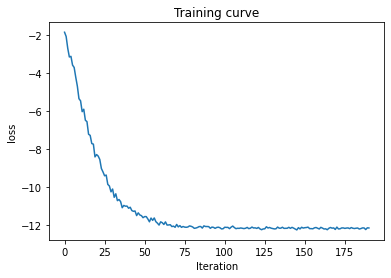

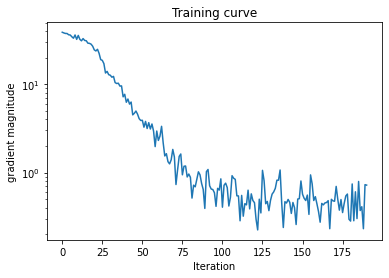

190


In [74]:
init_weights=np.random.rand(qnn.num_weights)*2*np.pi
weights=init_weights

nSteps=200
learning_rate=1e-2
loss=[]
gradMag=[]
for i in range(nSteps):
    
        

    vev=qnn.forward([], weights)[0][0]
    input_grad, weight_grad=qnn.backward([],weights)
    grad=weight_grad[0,0,:]
    weights=weights-learning_rate*grad

    loss.append(vev)
    gradMag.append(computeMag(grad))
    
    if i%10==0:
        
        clear_output(wait=True)
        plt.figure(1)

        callback_graph(loss)
        plt.figure(2)
        plt.yscale('log')
        callback_graph(gradMag,"gradient magnitude")
        print(i)


In [ ]:
def getGradient_pShift(qnn,weights):
    grad=[]
    for i in range(len(weights)):
        weights_plus=weights.copy()
        weights_plus[i]+=np.pi/2
        weights_minus=weights.copy()
        weights_minus[i]-=np.pi/2
        plus=qnn.forward([],weights_plus)
        minus=qnn.forward([],weights_minus)
        grad.append(0.5*(plus-minus))
    return np.array(grad)[:,0,0]

def getHessian_pShift(qnn,weights):
    #grad=[]
    hess=np.zeros([len(weights),len(weights)])
    angle_div=1/4
    angle=np.pi*angle_div
    for i in range(len(weights)):
        for j in np.arange(i,len(weights),1):
            tmpWeights=np.array([weights.copy()]*4)
            tmpWeights[0][i]+=angle
            tmpWeights[0][j]+=angle
            
            tmpWeights[1][i]-=angle
            tmpWeights[1][j]+=angle
            
            tmpWeights[2][i]+=angle
            tmpWeights[2][j]-=angle
        
            tmpWeights[3][i]-=angle
            tmpWeights[3][j]-=angle
            
            plusPlus=qnn.forward([],tmpWeights[0])
            minusPlus=qnn.forward([],tmpWeights[1])
            plusMinus=qnn.forward([],tmpWeights[2])
            minusMinus=qnn.forward([],tmpWeights[3])
                
            hess[i][j]=(angle_div*angle_div)*(plusPlus+minusMinus-minusPlus-plusMinus)
            hess[j][i]=(angle_div*angle_div)*(plusPlus+minusMinus-minusPlus-plusMinus)
            #grad.append((angle_div*angle_div)*(plusPlus+minusMinus-minusPlus-plusMinus))
    #hess=np.array(grad)[:,0,0].reshape(len(weights),len(weights))
    return hess
        